***`Can you build an algorithm that automatically detects potential pneumonia cases?`***

## Description



#### Importing libraries

In [2]:
import pydicom
import cv2
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
#from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Dropout


In [3]:
labels = pd.read_csv(
    "c:/Users/balde/OneDrive/Bureau/DSTI/Project/Deep Learning/DEEP-LEARNING-PROJECT/rsna-pneumonia-detection/stage_2_train_labels.csv")
# labels.head()

class_labels = pd.read_csv(
        "c:/Users/balde/OneDrive/Bureau/DSTI/Project/Deep Learning/DEEP-LEARNING-PROJECT/rsna-pneumonia-detection/stage_2_detailed_class_info.csv")

trainImagesPath = "c:/Users/balde/OneDrive/Bureau/DSTI/Project/Deep Learning/DEEP-LEARNING-PROJECT/rsna-pneumonia-detection/stage_2_train_images"
testImagesPath = "C:/Users/balde/OneDrive/Bureau/DSTI/Project/Deep Learning/DEEP-LEARNING-PROJECT/rsna-pneumonia-detection/stage_2_test_images"

### RSNA Pneumonia EDA

In [4]:
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [5]:
labels.shape

(30227, 6)

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


* **Check the null columns**

In [7]:
labels[labels.isnull().any(axis=1)].Target.value_counts()

Target
0    20672
Name: count, dtype: int64

We can see that all the null column values are with Target 0 indicating that those patients do not have penumonia

In [8]:
labels[~labels.isnull().any(axis=1)].Target.value_counts()

Target
1    9555
Name: count, dtype: int64

We can see that all the non null column values are with Target 1 indicating that those patients have pneumonia

* **Distribution of Targets**

In [9]:
labels.Target.value_counts()

Target
0    20672
1     9555
Name: count, dtype: int64

There are 20672 records with no pneumonia and 9555 with pneumonia

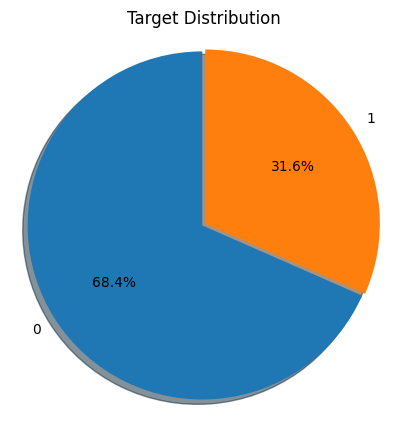

In [10]:
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

There are 31% of patients with pneumonia and the remaining are no pneumonia
There is a class imbalance issue

In [11]:
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)

Are there Unique Patients In Data Set ??  False


In [12]:
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

(3543, 6)

In [13]:
duplicateRowsDF.head(2)

patientId      x      y  width  height  Target
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [14]:
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

In [15]:
labels[labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId      x      y  width  height  Target
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

Examining one of the patient id which is duplicate , we can see that the x,y, widht and height is not the same
This indicates that the same patient has two bounding boxes in the same dicom image.

* **Reading the class Info Data Set**

In [16]:
class_labels.shape

(30227, 2)

In [17]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [18]:
class_labels['class'].value_counts()

class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64

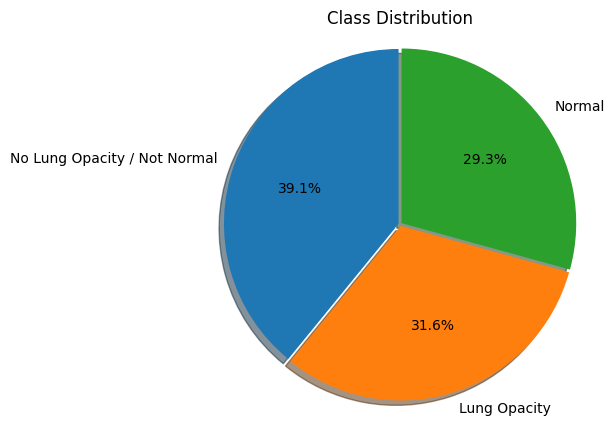

In [19]:
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [20]:
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

(3543, 2)

In [21]:
duplicateClassRowsDF.head(2)

patientId         class
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

In [22]:
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId         class
8  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

The same patient id has the same class even though they are duplicate

* Merging the class and labels data set into training dataset

In [23]:
# Conctinating the two dataset - 'labels' and 'class_labels':
training_data = pd.concat([labels, class_labels['class']], axis = 1)

training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

Text(0.5, 1.0, 'Class and Target Distribution')

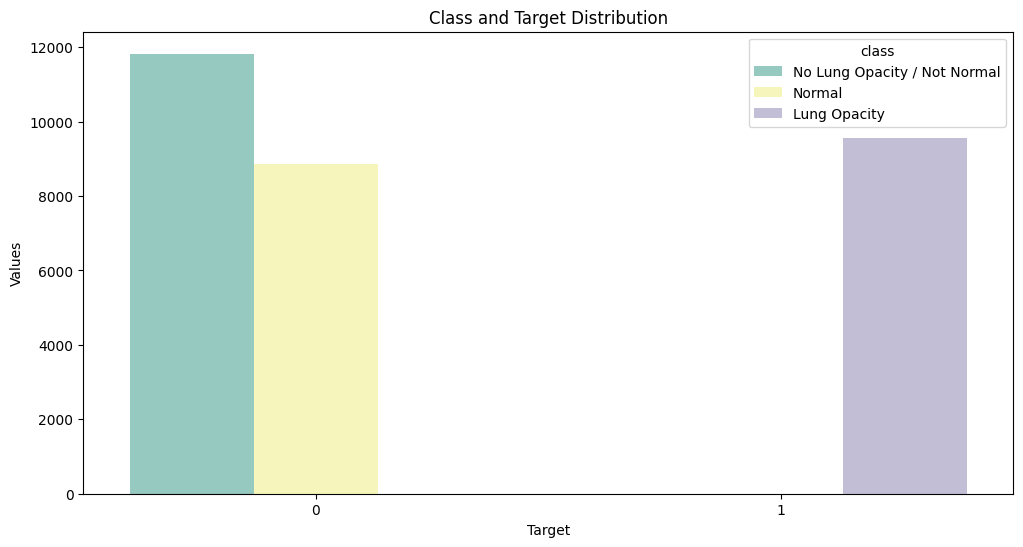

In [24]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data={'Values': temp.values}, index=temp.index).reset_index()
sns.barplot(ax=ax, x='Target', y='Values', hue='class', data=data_target_class, palette='Set3')
plt.title('Class and Target Distribution')

It shows that class distribution grouped by Target:   
- Target 0 has only Normal or No Lung Opacity class  
- Target 1 has only Lung Opacity class

In [25]:
import matplotlib.patches as patches
import pydicom as dcm
def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = 'C:/Users/balde/OneDrive/Bureau/DSTI/Project/Deep Learning/DEEP-LEARNING-PROJECT/rsna-pneumonia-detection/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

* Displaying Chest X-ray Images of Patients who have Pneuomina

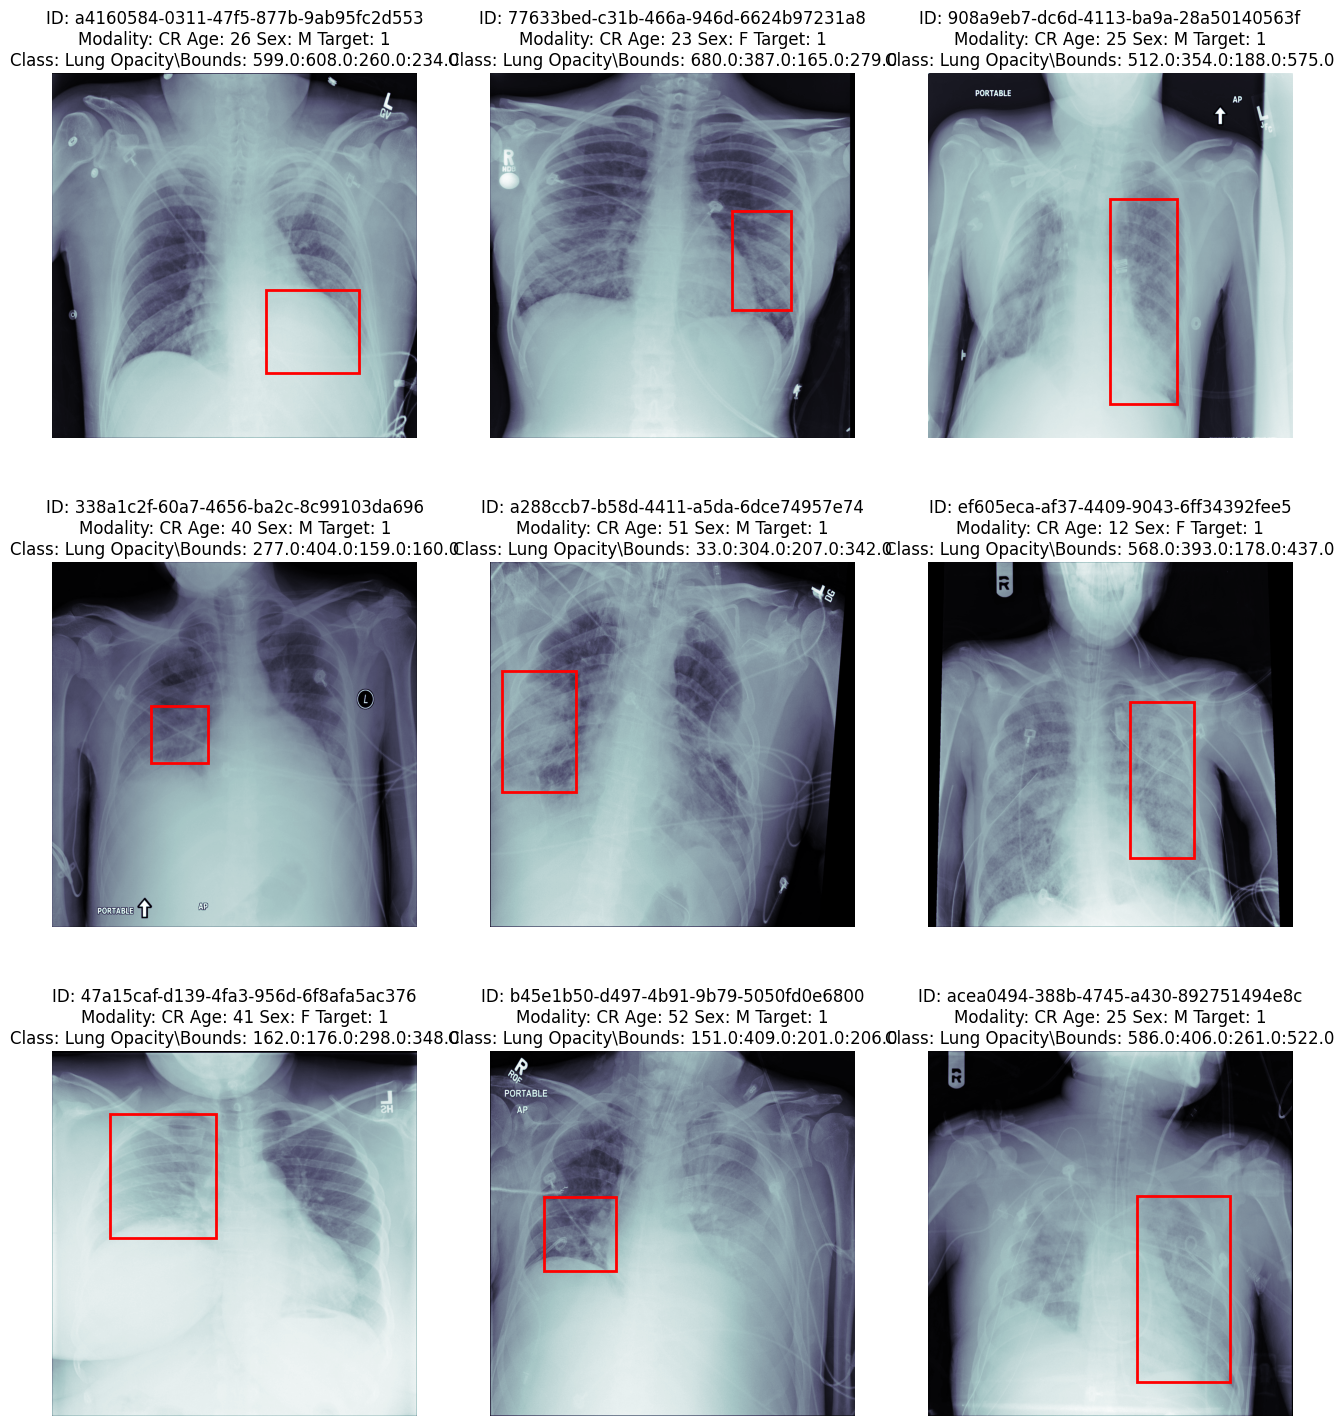

In [26]:
## checking few images which has pneuonia 
import math
inspectImages(training_data[training_data['Target']==1].sample(9))

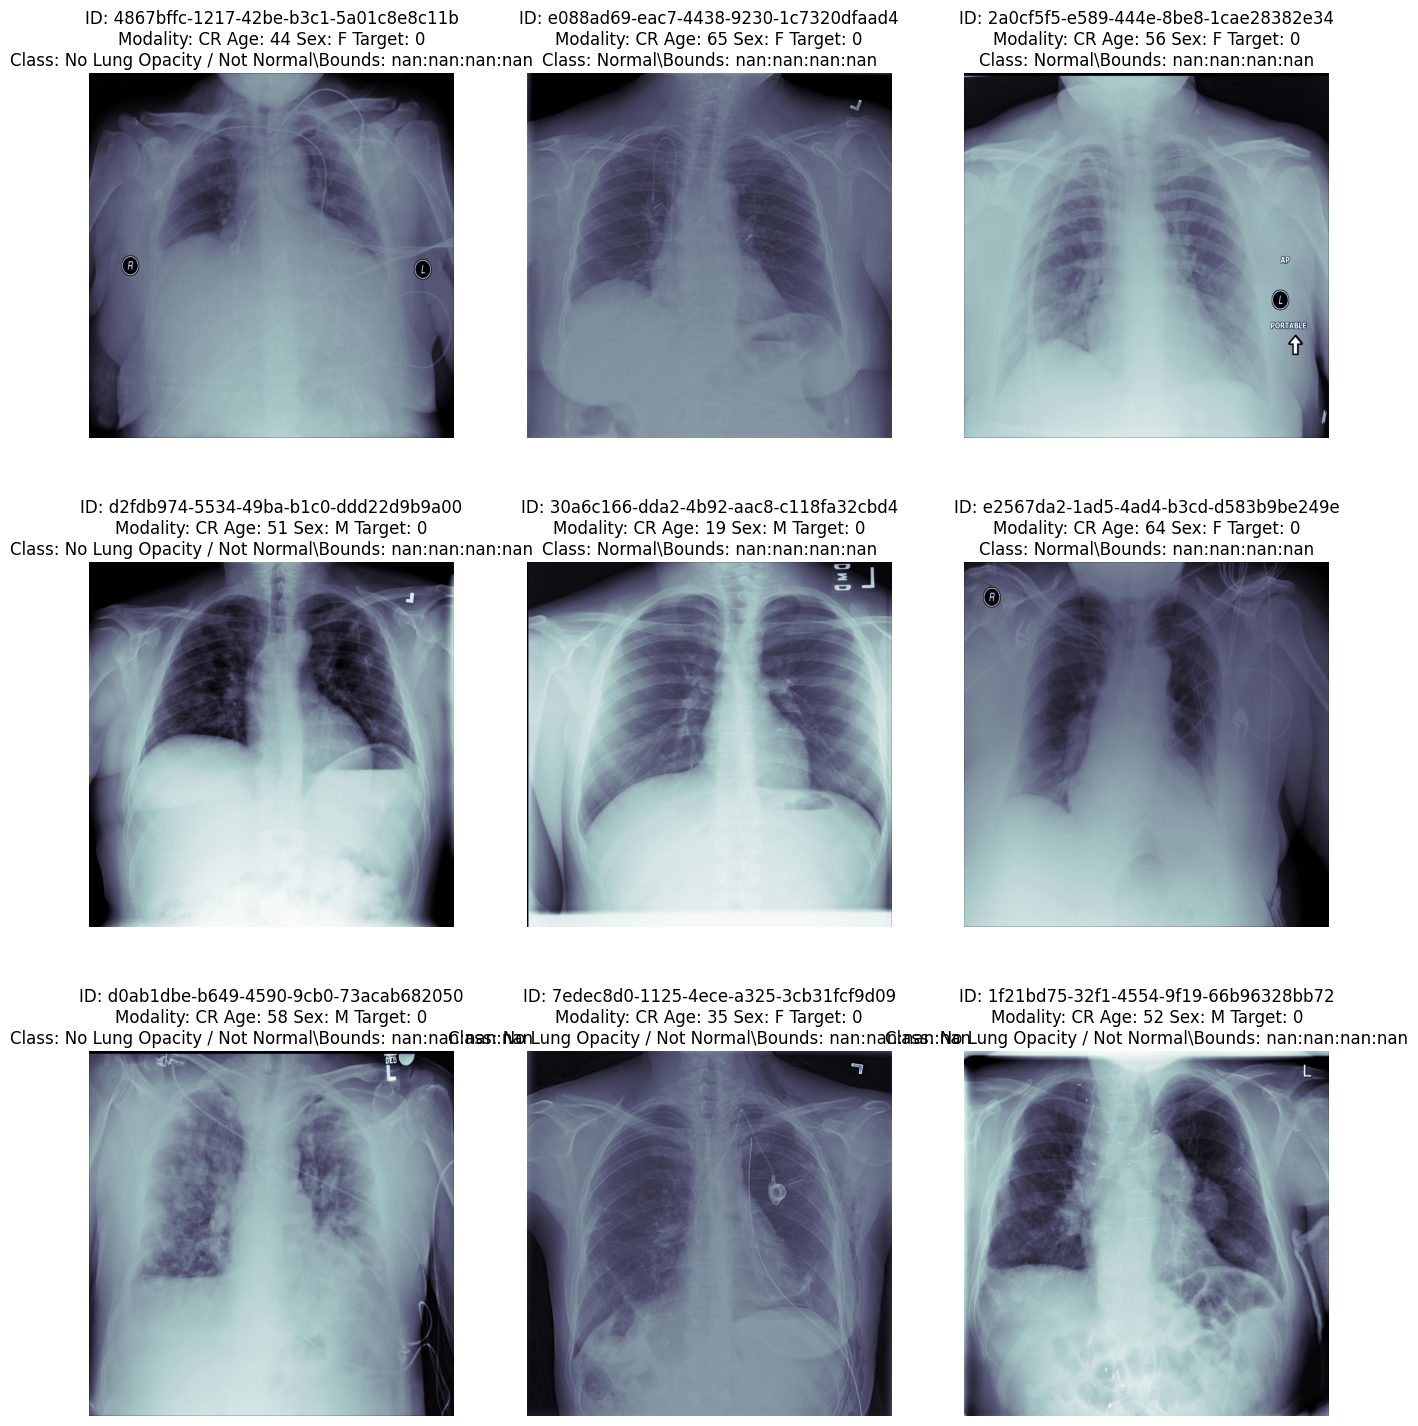

In [27]:
## checking few images which does not have pneuonia 
inspectImages(training_data[training_data['Target']==0].sample(9))

* **Reading the Dicom images meta data and appending it to the training set**

In [28]:
## DCIM image contain the meta data alon with it, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = 'C:/Users/balde/OneDrive/Bureau/DSTI/Project/Deep Learning/DEEP-LEARNING-PROJECT/rsna-pneumonia-detection/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

* Reading the image data and append it to the training_data dataset

In [29]:
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))

In [30]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


* Converting age to Numeric as the current data type is a String

In [31]:
training_data['age'] = training_data.age.astype(int)

In [32]:
training_data.describe(include="all").T

count unique                                   top   freq  \
patientId    30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x           9555.0    NaN                                   NaN    NaN   
y           9555.0    NaN                                   NaN    NaN   
width       9555.0    NaN                                   NaN    NaN   
height      9555.0    NaN                                   NaN    NaN   
Target     30227.0    NaN                                   NaN    NaN   
class        30227      3          No Lung Opacity / Not Normal  11821   
sex          30227      2                                     M  17216   
age        30227.0    NaN                                   NaN    NaN   

                 mean         std   min    25%    50%    75%    max  
patientId         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x          394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y           366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width      218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height     329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target       0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
sex               NaN         NaN   NaN    NaN    NaN    NaN    NaN  
age         46.797764    16.89294   1.0   34.0   49.0   59.0  155.0

- The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier  
- 50% of the patiens are of aroudn 49 age , the std deviation is 16 which suggest that age is not normally distubuted

In [33]:
training_data.sex.value_counts()

sex
M    17216
F    13011
Name: count, dtype: int64

* **Distbution of Sex Among the tragets**

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

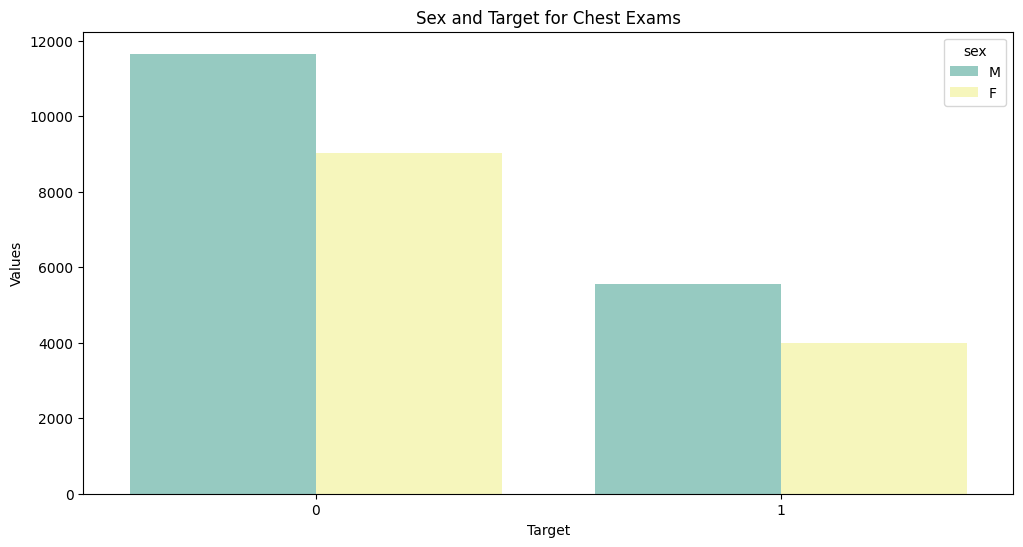

In [34]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

The number of males in both category are higher than women

* **Distbution of Sex Among the classes**

Text(0.5, 1.0, 'Sex and class for Chest Exams')

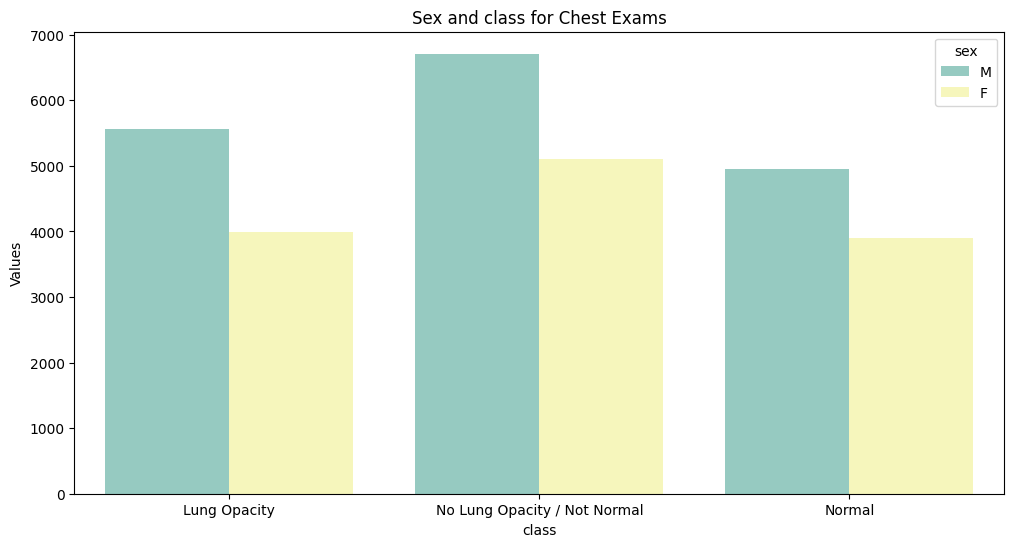

In [35]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

The number of males in all classes are higher than women

<Axes: xlabel='age', ylabel='Count'>

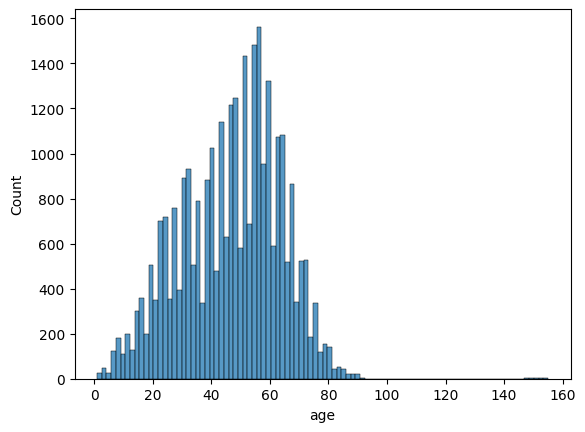

In [36]:
sns.histplot(training_data.age)

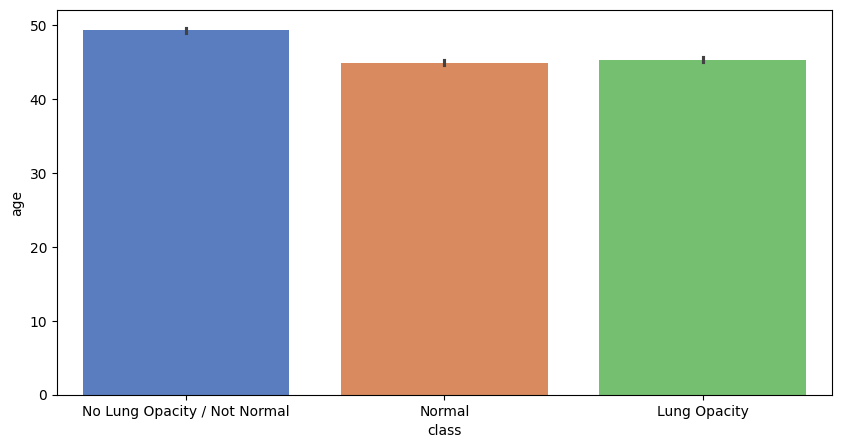

In [37]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=training_data, palette='muted', hue='class',legend=False)

This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

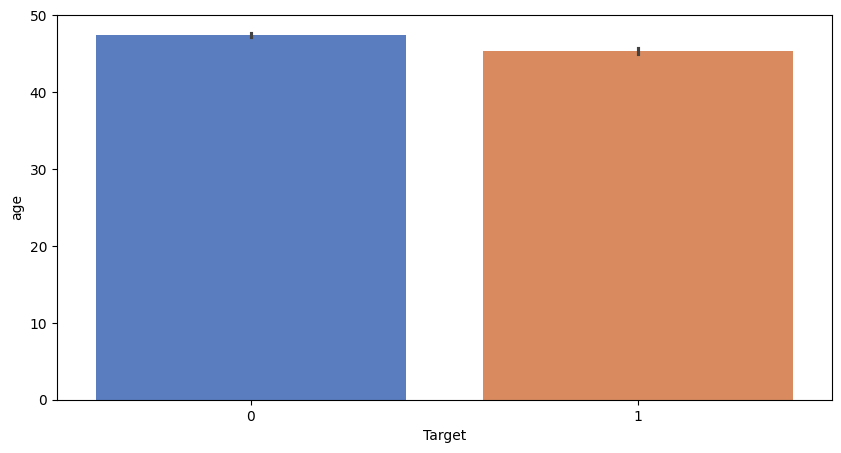

In [38]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=training_data, palette='muted', hue='Target',legend=False)

This is the distubution of Age with Target, maximum age of person with pneuomina is arund 45

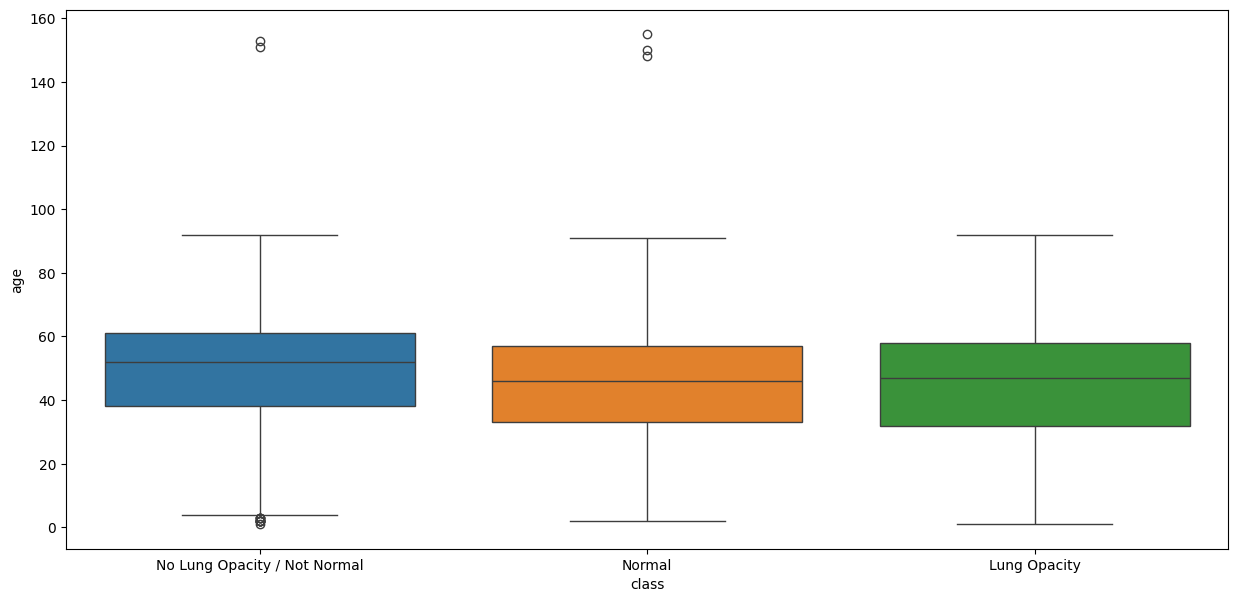

In [39]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= training_data, hue='class',legend=False)
plt.show()

The  class which has no pneuomia has few outliers , theie age is somewhere aroun 150 years

Distribution of `Age`: Overall and Target = 1


Text(0.5, 1.0, 'Distribution of PatientAge who have pneumonia')

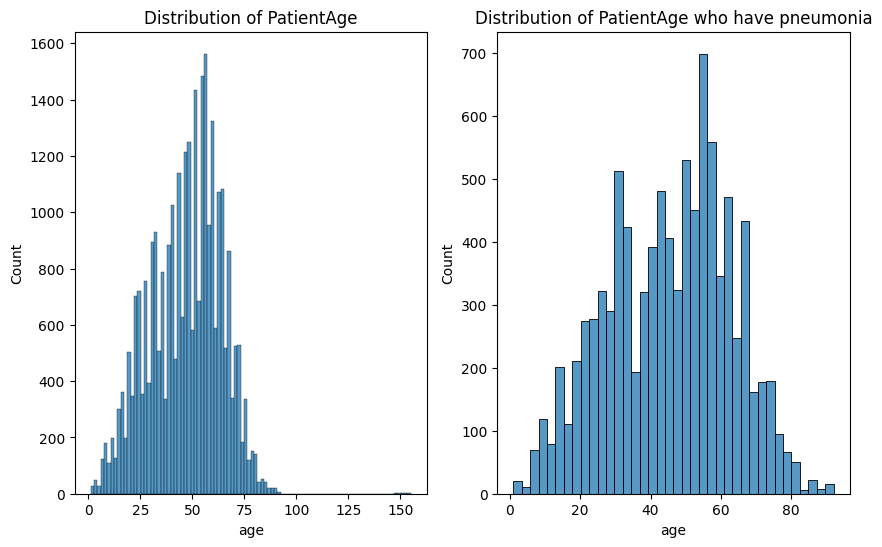

In [40]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(121)
g = sns.histplot(training_data['age'])
g.set_title('Distribution of PatientAge')

ax = fig.add_subplot(122)
g = sns.histplot(training_data.loc[training_data['Target'] == 1, 'age'])
g.set_title('Distribution of PatientAge who have pneumonia')

<Axes: >

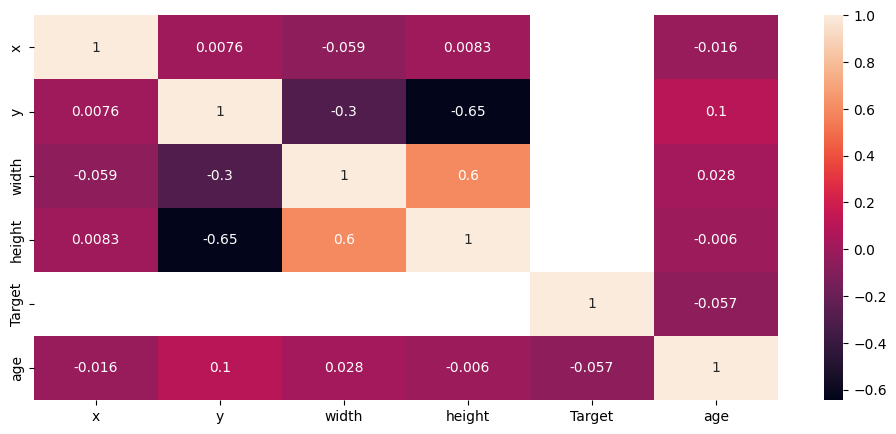

In [41]:
corr = training_data.corr(numeric_only=True)
plt.figure(figsize=(12, 5))
sns.heatmap(corr, annot=True)

There is high corelation between widht and height


### Model Building

* Just taking a few samples from the dataset

In [42]:
sample_trainigdata = training_data.groupby('class', group_keys=False).apply(lambda x: x.sample(800))

* Checking the training data set with class distbution

In [43]:
sample_trainigdata["class"].value_counts()

class
Lung Opacity                    800
No Lung Opacity / Not Normal    800
Normal                          800
Name: count, dtype: int64

In [44]:
sample_trainigdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 19535 to 7256
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  2400 non-null   object 
 1   x          800 non-null    float64
 2   y          800 non-null    float64
 3   width      800 non-null    float64
 4   height     800 non-null    float64
 5   Target     2400 non-null   int64  
 6   class      2400 non-null   object 
 7   sex        2400 non-null   object 
 8   age        2400 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(3)
memory usage: 178.1+ KB


* **Pre Processing the image**

In [45]:
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = 'C:/Users/balde/OneDrive/Bureau/DSTI/Project/Deep Learning/DEEP-LEARNING-PROJECT/rsna-pneumonia-detection/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

* **Reading the images into numpy array**

In [46]:
import numpy as np
images,labels = populateImage(sample_trainigdata)

In [47]:
images.shape , labels.shape

((2400, 128, 128, 3), (2400,))

The image is of 128*128 with 3 channels

* Checking one of the converted image 

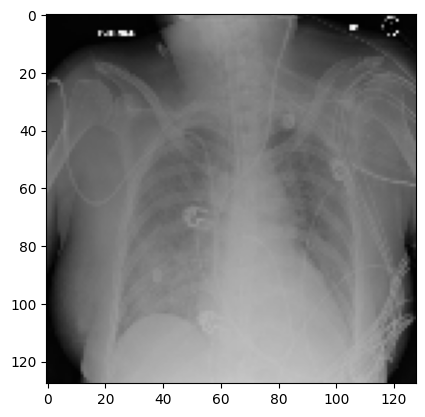

In [48]:
plt.imshow(images[100])

* check the unique labels

In [49]:
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

In [50]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

* **encoding the labels**

In [51]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

* **splitting into train ,test and validation data**

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

* **Function to create a dataframe for results**

In [53]:
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [54]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  model.summary()
  return model

In [55]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define Our model
ADJUSTED_IMAGE_SIZE = 128  # our actual image size
num_channels = 3  # for RGB images
num_classes = 3  # the actual number of classes in our dataset

cnn = cnn_model(ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, num_channels, num_classes)

# Define learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

# Compile our model
optimizer = RMSprop(learning_rate=lr_schedule)
cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                        

In [56]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.compat.v1.OptimizerOptions.OFF
session = InteractiveSession(config=config)

In [57]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf


# Fit our model
history = cnn.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=30)

Epoch 1/30
56/56 [==============================] - 124s 2s/step - loss: 7.0017 - accuracy: 0.3369 - val_loss: 1.0959 - val_accuracy: 0.3639
Epoch 2/30
56/56 [==============================] - 122s 2s/step - loss: 1.1223 - accuracy: 0.3464 - val_loss: 1.0974 - val_accuracy: 0.3528
Epoch 3/30
56/56 [==============================] - 124s 2s/step - loss: 1.1172 - accuracy: 0.3601 - val_loss: 1.0938 - val_accuracy: 0.3694
Epoch 4/30
56/56 [==============================] - 129s 2s/step - loss: 1.1110 - accuracy: 0.3625 - val_loss: 1.0892 - val_accuracy: 0.3722
Epoch 5/30
56/56 [==============================] - 122s 2s/step - loss: 1.1895 - accuracy: 0.3673 - val_loss: 1.0890 - val_accuracy: 0.4167
Epoch 6/30
56/56 [==============================] - 123s 2s/step - loss: 1.0987 - accuracy: 0.3571 - val_loss: 1.0822 - val_accuracy: 0.3806
Epoch 7/30
56/56 [==============================] - 121s 2s/step - loss: 1.0889 - accuracy: 0.3952 - val_loss: 1.0663 - val_accuracy: 0.4111
Epoch 8/30
56

In [58]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 4s 328ms/step - loss: 1.1911 - accuracy: 0.4083
Test loss: 1.191111445426941
Test accuracy: 0.40833333134651184


* **Extract the history of accuracy and loss values**

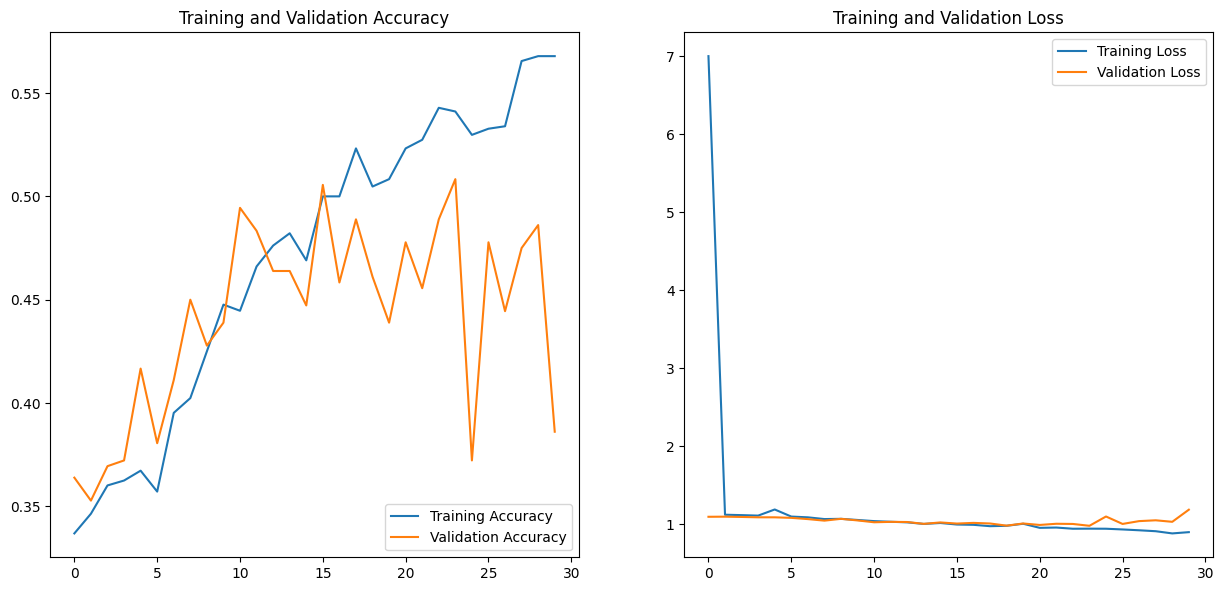

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

12/12 [==============================] - 4s 317ms/step


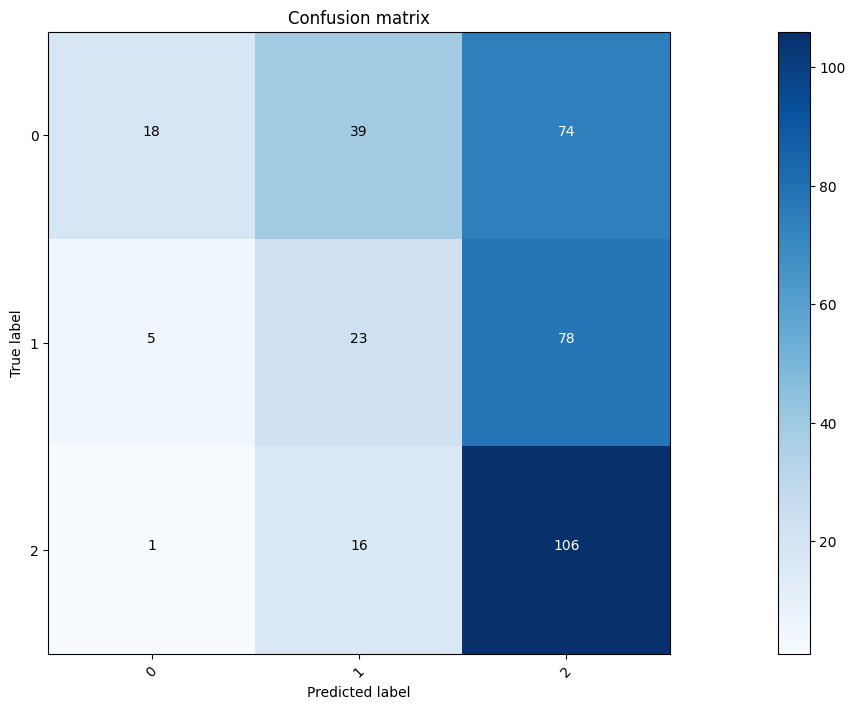

In [61]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))


Class 0 ,1 and 2 :  
- Class 0 is Lung Opacity   
- Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error  
- Class 2 is Normal  

In [62]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

12/12 [==============================] - 4s 355ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN  0.567857    0.408333     0.294872  0.216981        0.25      106.0

#### CNN with Tranfer learning using VGG16

* **Creating a Copy**

In [63]:
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

In [64]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

In [65]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu')
dropout_layer_1 = layers.Dropout(0.3)
dense_layer_2 = layers.Dense(50, activation='relu')
dropout_layer_2 = layers.Dropout(0.3)
dense_layer_3 = layers.Dense(20, activation='relu')
dropout_layer_3 = layers.Dropout(0.3)
prediction_layer = layers.Dense(3, activation='softmax')

cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    dense_layer_3,
    dropout_layer_3,
    prediction_layer
])

In [66]:
cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 63s 1s/step - loss: 1.4551 - accuracy: 0.3452 - val_loss: 0.6420 - val_accuracy: 0.4861
Epoch 2/30
53/53 [==============================] - 62s 1s/step - loss: 0.6887 - accuracy: 0.3149 - val_loss: 0.6714 - val_accuracy: 0.3333
Epoch 3/30
53/53 [==============================] - 65s 1s/step - loss: 0.6694 - accuracy: 0.3750 - val_loss: 0.6496 - val_accuracy: 0.4750
Epoch 4/30
53/53 [==============================] - 60s 1s/step - loss: 0.6373 - accuracy: 0.4530 - val_loss: 0.6005 - val_accuracy: 0.5222
Epoch 5/30
53/53 [==============================] - 61s 1s/step - loss: 0.5975 - accuracy: 0.4786 - val_loss: 0.5425 - val_accuracy: 0.5306
Epoch 6/30
53/53 [==============================] - 60s 1s/step - loss: 0.5589 - accuracy: 0.5286 - val_loss: 0.5321 - val_accuracy: 0.6167
Epoch 7/30
53/53 [==============================] - 61s 1s/step - loss: 0.5318 - accuracy: 0.5280 - val_loss: 0.5348 - val_accuracy: 0.6361
Epoch 8/30
53/53 [==

In [67]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 11s 903ms/step - loss: 0.7669 - accuracy: 0.6417
Test loss: 0.7668585181236267
Test accuracy: 0.6416666507720947


In [68]:
actual_train_accuracy = history.history['accuracy'][-1]
actual_val_accuracy = history.history['val_accuracy'][-1]

print('Actual Training Accuracy:', actual_train_accuracy)
print('Actual Validation Accuracy:', actual_val_accuracy)

Actual Training Accuracy: 0.7708333134651184
Actual Validation Accuracy: 0.6027777791023254


In [69]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",history.history['accuracy'][-1],fcl_accuracy)])

In [70]:
resultsDf1.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0             CNN  0.567857    0.408333     0.294872  0.216981        0.25   
0  CNN With VGG16  0.770833    0.641667          NaN       NaN         NaN   

   1_support  
0      106.0  
0        NaN

In [71]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

12/12 [==============================] - 4s 316ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0             CNN  0.567857    0.408333     0.294872  0.216981        0.25   
0  CNN With VGG16  0.770833    0.641667     0.294872  0.216981        0.25   

   1_support  
0      106.0  
0      106.0

### CNN with ResNet50

In [72]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras import layers

# Existing layers
resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')  # increased the number of neurons
dense_layer_2 = layers.Dense(128, activation='relu')  # increased the number of neurons
prediction_layer = layers.Dense(3, activation='softmax')

# Additional layers
additional_dense_layer = layers.Dense(64, activation='relu')  # reduced the number of neurons
dropout_layer_1 = layers.Dropout(0.5)  # You can adjust the dropout rate as needed
dropout_layer_2 = layers.Dropout(0.3)  # You can adjust the dropout rate as needed

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,  # Add the dropout layer after the first dense layer
    additional_dense_layer,  # Add the additional dense layer
    dropout_layer_2,  # Add another dropout layer after the additional dense layer
    dense_layer_2,
    prediction_layer
])

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [74]:
#Trainign the model
history = cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 191s 3s/step - loss: 0.7407 - accuracy: 0.4679 - val_loss: 11.5825 - val_accuracy: 0.3222
Epoch 2/30
53/53 [==============================] - 180s 3s/step - loss: 0.5561 - accuracy: 0.5780 - val_loss: 7.8479 - val_accuracy: 0.3833
Epoch 3/30
53/53 [==============================] - 176s 3s/step - loss: 0.5086 - accuracy: 0.6238 - val_loss: 3.6460 - val_accuracy: 0.5000
Epoch 4/30
53/53 [==============================] - 187s 4s/step - loss: 0.4669 - accuracy: 0.6661 - val_loss: 0.8054 - val_accuracy: 0.4611
Epoch 5/30
53/53 [==============================] - 175s 3s/step - loss: 0.4475 - accuracy: 0.6756 - val_loss: 0.9931 - val_accuracy: 0.5778
Epoch 6/30
53/53 [==============================] - 174s 3s/step - loss: 0.4178 - accuracy: 0.7030 - val_loss: 0.6430 - val_accuracy: 0.5250
Epoch 7/30
53/53 [==============================] - 174s 3s/step - loss: 0.4073 - accuracy: 0.7286 - val_loss: 5.9074 - val_accuracy: 0.3278
Epoch 8/30
5

In [75]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 8s 687ms/step - loss: 1.3601 - accuracy: 0.6083
Test loss: 1.360148310661316
Test accuracy: 0.6083333492279053


In [76]:
resultsDf2 = pd.concat([resultsDf1, createResultDf("CNN With ResNet50",history.history['accuracy'][-1],fcl_accuracy)])

In [77]:
resultsDf2.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.567857    0.408333     0.294872  0.216981        0.25   
0     CNN With VGG16  0.770833    0.641667     0.294872  0.216981        0.25   
0  CNN With ResNet50  0.972619    0.608333          NaN       NaN         NaN   

   1_support  
0      106.0  
0      106.0  
0        NaN

In [78]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf2[data+"_"+subData] = reportData[data][subData]

12/12 [==============================] - 5s 412ms/step


12/12 [==============================] - 10s 663ms/step


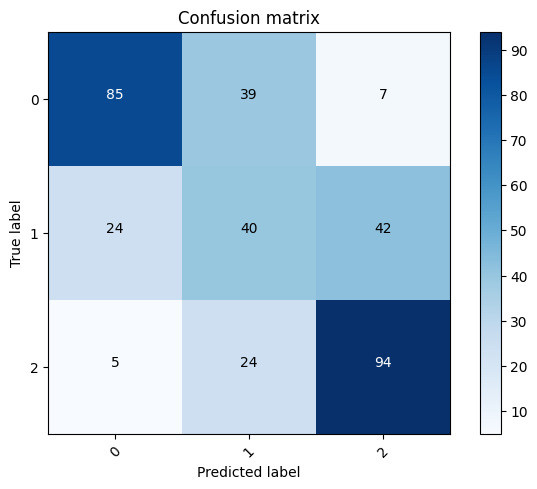

In [79]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1) 

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(3))

In [80]:
resultsDf2.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.567857    0.408333     0.294872  0.216981        0.25   
0     CNN With VGG16  0.770833    0.641667     0.294872  0.216981        0.25   
0  CNN With ResNet50  0.972619    0.608333     0.294872  0.216981        0.25   

   1_support  
0      106.0  
0      106.0  
0      106.0

### CNN with Xception

In [81]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers, models

xception_base_model = Xception(include_top=False, weights='imagenet', input_shape=X_train[0].shape)

train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(1024, activation='relu')
dropout_layer_1 = layers.Dropout(0.3)
dense_layer_2 = layers.Dense(512, activation='relu')
dropout_layer_2 = layers.Dropout(0.3)
dense_layer_3 = layers.Dense(256, activation='relu')
dropout_layer_3 = layers.Dropout(0.3)
dense_layer_4 = layers.Dense(128, activation='relu')
dropout_layer_4 = layers.Dropout(0.3)
dense_layer_5 = layers.Dense(64, activation='relu')
dropout_layer_5 = layers.Dropout(0.3)
dense_layer_6 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_xception_model = models.Sequential([
    xception_base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    dense_layer_3,
    dropout_layer_3,
    dense_layer_4,
    dropout_layer_4,
    dense_layer_5,
    dropout_layer_5,
    dense_layer_6,
    prediction_layer
])

In [82]:
# Compile the model
cnn_xception_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [83]:
# Train the model
history = cnn_xception_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 328s 6s/step - loss: 0.6380 - accuracy: 0.4071 - val_loss: 31.4029 - val_accuracy: 0.3306
Epoch 2/30
53/53 [==============================] - 228s 4s/step - loss: 0.5753 - accuracy: 0.4708 - val_loss: 4.1578 - val_accuracy: 0.3889
Epoch 3/30
53/53 [==============================] - 218s 4s/step - loss: 0.5158 - accuracy: 0.5595 - val_loss: 4.9949 - val_accuracy: 0.4861
Epoch 4/30
53/53 [==============================] - 228s 4s/step - loss: 0.4721 - accuracy: 0.6060 - val_loss: 1.7472 - val_accuracy: 0.5250
Epoch 5/30
53/53 [==============================] - 217s 4s/step - loss: 0.4730 - accuracy: 0.5940 - val_loss: 1.1279 - val_accuracy: 0.5639
Epoch 6/30
53/53 [==============================] - 236s 4s/step - loss: 0.5120 - accuracy: 0.5851 - val_loss: 12.6965 - val_accuracy: 0.3889
Epoch 7/30
53/53 [==============================] - 226s 4s/step - loss: 0.4589 - accuracy: 0.6131 - val_loss: 2.6919 - val_accuracy: 0.5417
Epoch 8/30


In [84]:
fcl_loss, fcl_accuracy = cnn_xception_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 13s 734ms/step - loss: 131.2711 - accuracy: 0.3417
Test loss: 131.2710723876953
Test accuracy: 0.34166666865348816


In [85]:
resultsDf3 = pd.concat([resultsDf2, createResultDf("CNN With Xception",history.history['accuracy'][-1],fcl_accuracy)])

In [86]:
resultsDf3.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.567857    0.408333     0.294872  0.216981        0.25   
0     CNN With VGG16  0.770833    0.641667     0.294872  0.216981        0.25   
0  CNN With ResNet50  0.972619    0.608333     0.294872  0.216981        0.25   
0  CNN With Xception  0.968452    0.341667          NaN       NaN         NaN   

   1_support  
0      106.0  
0      106.0  
0      106.0  
0        NaN

In [87]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf3[data+"_"+subData] = reportData[data][subData]
resultsDf3

12/12 [==============================] - 5s 395ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.567857    0.408333      0.38835  0.377358    0.382775   
0     CNN With VGG16  0.770833    0.641667      0.38835  0.377358    0.382775   
0  CNN With ResNet50  0.972619    0.608333      0.38835  0.377358    0.382775   
0  CNN With Xception  0.968452    0.341667      0.38835  0.377358    0.382775   

   1_support  
0      106.0  
0      106.0  
0      106.0  
0      106.0

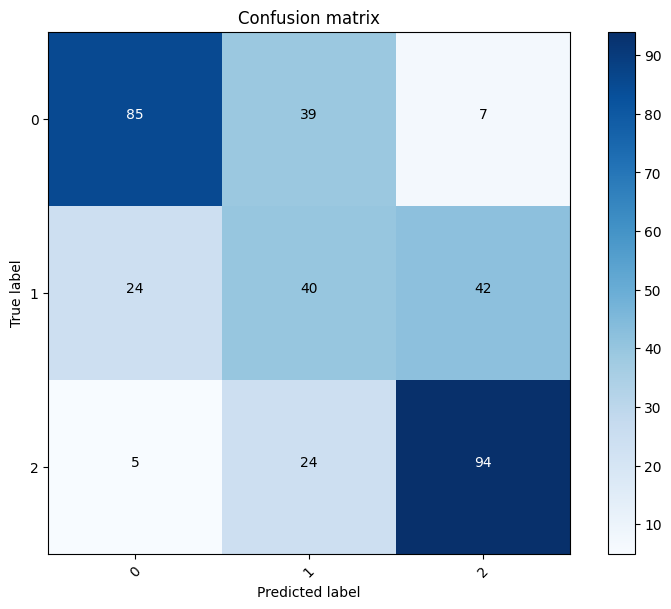

In [88]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Define the function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
class_names = [0, 1, 2]  # Replace with your actual class names
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False)

# Display the plot
plt.show()

In [89]:
resultsDf3.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.567857    0.408333      0.38835  0.377358    0.382775   
0     CNN With VGG16  0.770833    0.641667      0.38835  0.377358    0.382775   
0  CNN With ResNet50  0.972619    0.608333      0.38835  0.377358    0.382775   
0  CNN With Xception  0.968452    0.341667      0.38835  0.377358    0.382775   

   1_support  
0      106.0  
0      106.0  
0      106.0  
0      106.0

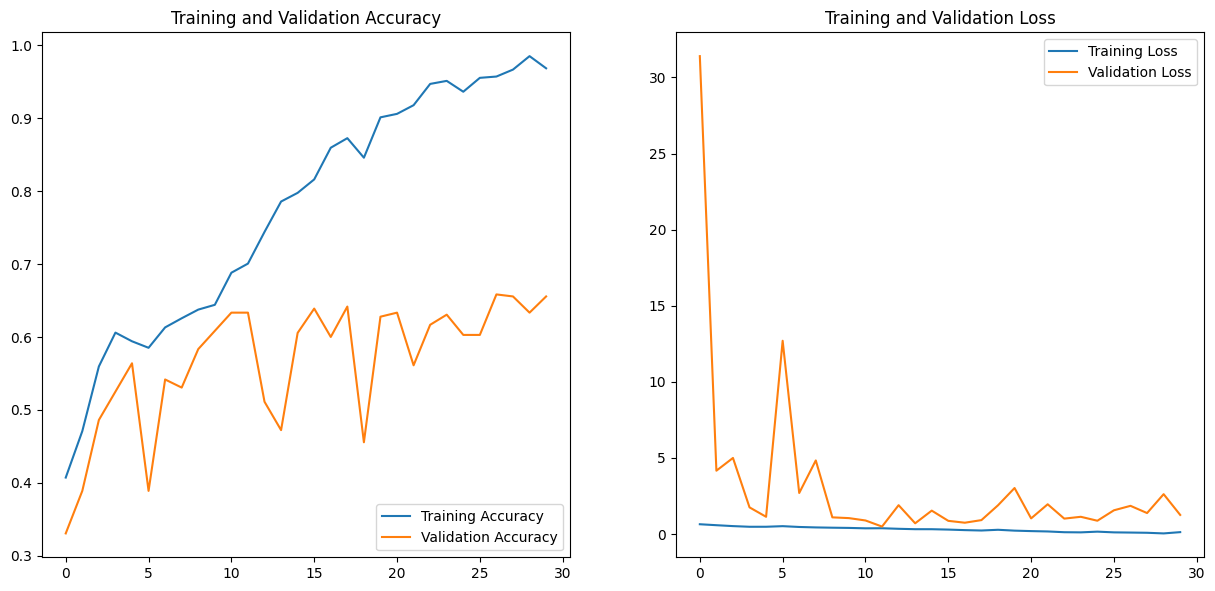

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()